In [1]:
import torch

from torchvision.models import resnet34, ResNet34_Weights
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, Grayscale

from zennit.attribution import Gradient, SmoothGrad
from zennit.torchvision import ResNetCanonizer
from zennit.composites import EpsilonGammaBox, EpsilonPlusFlat
from zennit.image import imgify, imsave

from PIL import Image

from tempo.models import NewTempoLinear

In [2]:
# define the base image transform
transform_img = Compose([
    Resize(128),
    # CenterCrop(128)
])
# define the normalization transform
transform_norm = Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
# define the full tensor transform
transform = Compose([
    transform_img,
    ToTensor(),
    transform_norm,
])

# load the image
image = Image.open('asl_7.png')

# transform the PIL image and insert a batch-dimension
data = transform(image)[None]

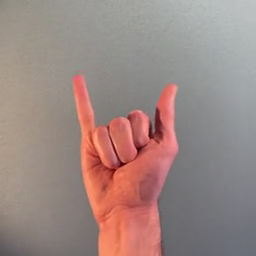

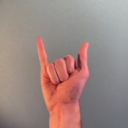

In [3]:
# display the original image
display(image)
# display the resized and cropped image
image_t = transform_img(image)
display(image_t)

In [4]:
data.shape

torch.Size([1, 3, 128, 128])

In [5]:
# load the model and set it to evaluation mode
# model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1).eval()
weights = torch.load('../model_zoo/asl1.pth')
model = NewTempoLinear(out_features=10, weights=None,freeze_backbone=True)
model.load_state_dict(weights)
model.requires_grad = True
model.eval()

NewTempoLinear(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [6]:
model(data)

tensor([[ 0.0657, -2.8924, -1.3292,  2.4994, -1.7641,  2.3816, -1.2398,  3.1259,
         -0.4041, -1.5095]], grad_fn=<AddmmBackward0>)

In [7]:
# use the ResNet-specific canonizer
canonizer = ResNetCanonizer()

# create a composite, specifying the canonizers
composite = EpsilonPlusFlat(canonizers=[canonizer])

# choose a target class for the attribution (label 437 is lighthouse)
target = torch.eye(10)[[1]]

# create the attributor, specifying model and composite
with Gradient(model=model, composite=composite) as attributor:
    # compute the model output and attribution
    output, attribution = attributor(data, target)

print(f'Prediction: {output.argmax(1)[0].item()}')
# 0: rock, 1: scissors, 2: paper

Prediction: 7


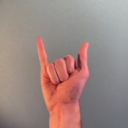

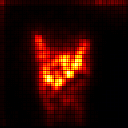

In [9]:
# sum over the channels
relevance = attribution.sum(1)

# create an image of the visualize attribution
img = imgify(relevance, symmetric=True, cmap='coldnhot')

# show the image
display(image_t)
display(img)